In [1]:
import json
import multiprocessing as mp
import os
import sys

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gc_utils import iteration_name, snapshot_name  # type: ignore
from scipy.interpolate import interp1d

In [2]:
path = "/Users/z5114326/Documents/GitHub/gc_statistics/data/mass_data/m12i_gc_type_mass_data.hdf5"
mass_data = proc_data = h5py.File(path, "r")  # open processed data file

it = 0
it_id = iteration_name(it)

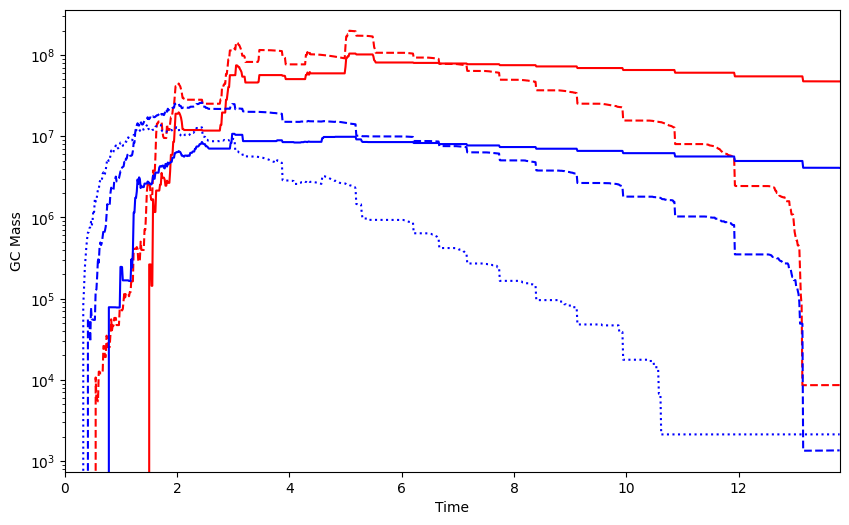

In [29]:
plt.figure(figsize=(10, 6))

time_type = "time"

time = mass_data[time_type][()]

mass_0 = mass_data[it_id]["0"][time_type]["mass"][()]
mass_1 = mass_data[it_id]["1"][time_type]["mass"][()]

mass_2 = mass_data[it_id]["2"][time_type]["mass"][()]
mass_3 = mass_data[it_id]["3"][time_type]["mass"][()]
mass_4 = mass_data[it_id]["4"][time_type]["mass"][()]

plt.plot(time, mass_0, c="r", ls="-", label="In-Situ Survive")
plt.plot(time, mass_1, c="r", ls="--", label="In-Situ Destroyed")

plt.plot(time, mass_2, c="b", ls="-", label="Ex-Situ Survive")
plt.plot(time, mass_3, c="b", ls="--", label="Ex-Situ Destroyed Post Accretion")
plt.plot(time, mass_4, c="b", ls=":", label="Ex-Situ Destroyed Pre Accretion")

plt.xlabel("Time")
plt.ylabel("GC Mass")

plt.xlim([np.min(time), np.max(time)])

# plt.legend(loc="upper right")
plt.yscale("log")

In [30]:
# This might be a result of timing and using the "kind = previous" for interpolation
# I should look into this

# I changed to "kind = nearest" for interpolation and still see this mass difference
# I should look into this
# It could be from an issue with timing between snapshots

mass_0[-1], mass_1[-1], mass_2[-1], mass_3[-1], mass_4[-1]

(47309727.77307851, 8616.0, 4074514.909508698, 1353.0, 2130.0)

In [31]:
sim = "m12i"
sim_dir = "/Users/z5114326/Documents/simulations/"

proc_file = sim_dir + sim + "/" + sim + "_processed.hdf5"
proc_data = h5py.File(proc_file, "r")  # open processed data file

In [32]:
np.sum((mass_0[-1], mass_1[-1], mass_2[-1], mass_3[-1], mass_4[-1]))

51396341.68258721

In [33]:
np.sum(10 ** proc_data["it000"]["snapshots"]["snap600"]["mass"][()])

51384242.68258721

In [34]:
# It is excellent that this equals the above cell. I need to find out why
# mass_1[-1], mass_3[-1], mass_4[-1] are not 0 (they should be)
np.sum((mass_0[-1], mass_2[-1]))

51384242.68258721

In [35]:
# maybe this was a really old GC that was accreted very late.
# I should look into this.

# I don't think the above graph is very insightful

mass_4[-1], time[-1]

(2130.0, 13.798746883)

In [11]:
gc_data_file = "/Users/z5114326/Documents/GitHub/gc_statistics/data/mass_data/m12i_gc_mass_data.hdf5"
gc_data = h5py.File(gc_data_file, "r")  # open processed data file

In [19]:
gc_data["it000"]["100008371"]["time"][()]

array([0.87964455, 0.96011515, 1.07393044, 1.20896622, 1.38483617,
       1.58686854, 1.85183633, 2.21035546, 2.529     ])

In [45]:
gc_4_lst = []

for gc in gc_data["it000"].keys():
    type_flag = gc_data["it000"][gc]["type_flag"][()]
    if type_flag == 4:
        gc_4_lst.append(gc)

In [48]:
gc_data["it000"]["100034721"].keys()

<KeysViewHDF5 ['acc_time', 'form_time', 'group_id', 'log_mass', 'mass_loss', 'mass_loss_detectable', 'time', 'type_flag']>

In [59]:
gc_data["it000"]["100034721"]["log_mass"][-2]

3.29

In [65]:
mass_4[-1]

2130.0

In [67]:
for gc in gc_4_lst:
    log_mass = gc_data["it000"][gc]["log_mass"][-1]
    # mass = 10**log_mass
    if not np.isnan(log_mass):
        print(log_mass)

In [76]:
mass_4[-1]

i = 1
while mass_4[-i] == mass_4[-1]:
    i += 1

print(i)

214


In [80]:
mass_4[-214]

2129.0

In [83]:
for gc in gc_4_lst:
    time = gc_data["it000"][gc]["time"][()]

    if time[-1] > 10:
        print(gc)

    # plt.plot(time, mass)


44082976
46631635
54973279
56465151
61257155


In [86]:
pub_data = sim_dir + "snapshot_times_public.txt"
pub_snaps = pd.read_table(pub_data, comment="#", header=None, sep=r"\s+")
pub_snaps.columns = [
    "index",
    "scale_factor",
    "redshift",
    "time_Gyr",
    "lookback_time_Gyr",
    "time_width_Myr",
]

In [117]:
src_dat = proc_data["it000"]["source"]
ana_mask = np.array(src_dat["analyse_flag"]) == 1

gc_test_lst = []

for gc in gc_4_lst:
    # gc = gc_4_lst[0]

    # np.array(src_dat["gc_id"])[ana_mask]

    idx = np.where(np.array(src_dat["gc_id"])[ana_mask] == int(gc))[0][0]
    idx

    t_form = src_dat["form_time"][idx]
    t_close = np.min(pub_snaps[pub_snaps["time_Gyr"] > t_form]["time_Gyr"])

    t_dis = src_dat["t_dis"][idx]

    if (t_dis < t_close) and (t_dis != -1):
        print(gc, t_form, t_dis)
        gc_test_lst.append(gc)

104221059 5.062643296 5.966
105009033 5.062643296 5.695
106780614 5.037241784 5.666
107373320 5.037241784 5.917
107575187 5.037241784 5.532
107768854 5.037241784 5.864
107772553 5.037241784 5.979
122070200 5.037241784 5.879
122979854 5.037241784 5.865
127902518 5.011860801 5.953
131732766 5.011860801 5.936
133420338 5.037241784 5.898
133666281 5.037241784 5.932
29126692 5.062643296 5.889
29328754 5.062643296 5.876
34503124 5.062643296 5.898
36670486 5.062643296 5.547


In [123]:
# for gc in gc_test_lst:
gc = gc_test_lst[0]

for gc in gc_test_lst:
    # gc_data["it000"][gc]["time"][()]
    print(10 ** gc_data["it000"][gc]["log_mass"][-2])

1552.3870099580815
1599.5580286146694
2552.701302661247
2741.5741719278835
1566.7510701081485
2172.7011788637456
2301.441817408509
620.8690342300638
2202.9264630534562
1874.9945080674192
1531.0874616820304
792.5013304804718
1438.798578255845
1088.9300933334332
769.1304402866099
1336.5955165464418
312.6079367123956


In [124]:
mass_4[-1]

2130.0

# TESTING OF GROUP 4

In [227]:
def time_interpolate(x, y, common_grid):
    # interp_func = interp1d(x, y, kind="nearest", bounds_error=False, fill_value=(0, 1))
    interp_func = interp1d(x, y, kind="previous", bounds_error=False, fill_value=(0, 0))
    return interp_func(common_grid)

In [228]:
time_grid = np.linspace(0, np.max(pub_snaps["time_Gyr"]), 1000)

In [229]:
it_type_dict = {}
it_type_dict["4"] = {}

for type_flag_val in range(4, 5):
    it_type_dict[str(type_flag_val)] = {}

    #######################################################################################
    # need to make a mass list for each time frame
    # cosmic time
    time_len = len(time_grid)
    it_type_dict[str(type_flag_val)]["time"] = {}
    it_type_dict[str(type_flag_val)]["time"]["mass"] = np.zeros(time_len)
    it_type_dict[str(type_flag_val)]["time"]["mass_loss"] = np.zeros(time_len)
    it_type_dict[str(type_flag_val)]["time"]["mass_loss_det"] = np.zeros(time_len)

    # formation time
    time_len = len(time_grid)
    it_type_dict[str(type_flag_val)]["form_time"] = {}
    it_type_dict[str(type_flag_val)]["form_time"]["mass"] = np.zeros(time_len)
    it_type_dict[str(type_flag_val)]["form_time"]["mass_loss"] = np.zeros(time_len)
    it_type_dict[str(type_flag_val)]["form_time"]["mass_loss_det"] = np.zeros(time_len)

    # accretion time
    if type_flag_val > 1:
        time_len = len(time_grid)
        it_type_dict[str(type_flag_val)]["acc_time"] = {}
        it_type_dict[str(type_flag_val)]["acc_time"]["mass"] = np.zeros(time_len)
        it_type_dict[str(type_flag_val)]["acc_time"]["mass_loss"] = np.zeros(time_len)
        it_type_dict[str(type_flag_val)]["acc_time"]["mass_loss_det"] = np.zeros(time_len)

In [230]:
for gc_id in gc_4_lst:
    # if gc_id in gc_test_lst:
    #     print(gc_id)
    #     continue

    type_flag = 4

    time_lst = gc_data["it000"][gc_id]["time"]

    log_mass_lst = gc_data["it000"][gc_id]["log_mass"]

    mass_loss_lst = gc_data["it000"][gc_id]["mass_loss"]
    mass_loss_det_lst = gc_data["it000"][gc_id]["mass_loss_detectable"]

    mass_lst = []
    for log_mass in log_mass_lst:
        if not np.isnan(log_mass):
            mass = 10**log_mass
        else:
            mass = 0
        # if mass == 2130.0:
        #     print(mass)
        mass_lst.append(mass)

    # print(mass_lst[-1])
    ########################################################################################3
    # cosmic time
    time_mass = time_interpolate(time_lst, mass_lst, time_grid)

    # if time_mass[-1] != 0:
    #     print(gc_id)

    time_mass_loss = time_interpolate(time_lst, mass_loss_lst, time_grid)
    time_mass_loss_det = time_interpolate(time_lst, mass_loss_det_lst, time_grid)

    it_type_dict[str(type_flag)]["time"]["mass"] += time_mass
    it_type_dict[str(type_flag)]["time"]["mass_loss"] += time_mass_loss
    it_type_dict[str(type_flag)]["time"]["mass_loss_det"] += time_mass_loss_det

In [231]:
time_mass[-1]

0.0

In [232]:
gc_4_lst

['100034721',
 '100057312',
 '100059480',
 '100061108',
 '100061647',
 '100223789',
 '100225395',
 '100236040',
 '100236085',
 '100245869',
 '100250220',
 '100359806',
 '100360641',
 '100421890',
 '100609501',
 '100623554',
 '100815365',
 '100981461',
 '100991601',
 '101002491',
 '101129313',
 '101132832',
 '101132833',
 '101310598',
 '101321283',
 '101323229',
 '101573065',
 '101573602',
 '101575243',
 '10167173',
 '101871396',
 '101878655',
 '101879042',
 '102127789',
 '102137334',
 '102257237',
 '102286585',
 '102325054',
 '102341966',
 '102448665',
 '102471740',
 '102691493',
 '103027337',
 '103028013',
 '10303409',
 '103046662',
 '10306206',
 '103093442',
 '103093983',
 '103100519',
 '10321882',
 '103223673',
 '103232061',
 '103293225',
 '103293775',
 '103414537',
 '103422783',
 '103424386',
 '103608262',
 '103608940',
 '103801715',
 '103802046',
 '103802377',
 '103819408',
 '103871523',
 '103996210',
 '103996547',
 '103996882',
 '103997228',
 '104003170',
 '104047353',
 '10404842

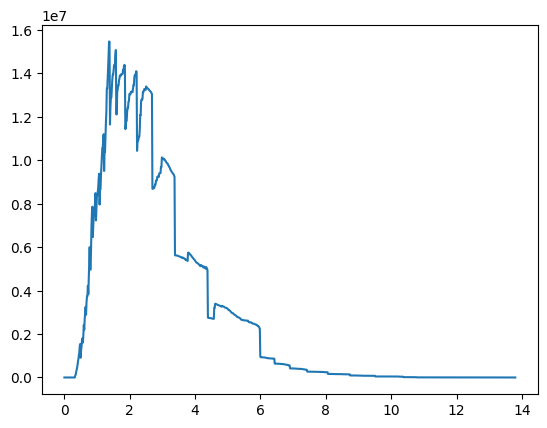

In [233]:
mass_lst = it_type_dict[str(type_flag)]["time"]["mass"]

plt.plot(time_grid, mass_lst)

In [234]:
mass_lst[-1]

0.0

In [29]:
# proc_data.close()
# mass_data.close()